In [12]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import pandas as pd

### Carga de datos

In [13]:
df = pd.read_csv('data/Finaltrain.csv')
df = df.sample(frac=1).reset_index(drop=True)
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [14]:
train_data.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_length,word_count,number_count,punctuation_count,stopword_count
0,be99c23d6b55,3b9047,The ancient Egyptian government was run by a P...,2.172932,0.239217,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,1435,249,1,32,109
1,7b21a8721b9a,3b9047,Different social classes were involved in this...,0.547065,0.546700,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,853,149,1,16,64
2,9c46c75daf34,3b9047,The structure of the ancient Egyptian system o...,1.108294,1.628178,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,770,146,0,19,87
3,cdcef6b09c11,814d6b,It devloped over such a short period of time b...,-0.093814,0.503833,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave ex...,283,54,0,3,29
4,676f0132d067,ebad26,"1) ""would often be found sour, and how they wo...",-1.316832,-1.042875,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,207,41,0,8,19


In [15]:
train_data['text'].tolist()

["The ancient Egyptian government was run by a Pharoah. The Pharoah was considered a God or God-like and was very highly praised. They had control over all their subjects and citizens. They usually were built pyramids for their tombs. Under the Pharoah was a minister or vizier. The vizier's job was to collect taxes and to make sure everyone paid them.  Scribes worked with the vizier because they held government records. Scribes were important because they could read and write.  Then there were nobles and priests. Priests would feed and please the gods to make them happy.  Nobles would hold government posts and they profited from the gifts. There were also soldiers who would fight in wars. And workers such as craftsmen and women and physicians. They were in the middle class.  Then there were the merchants who sold goods to the citizens who bought them. At the bottom, there were farmers and slaves. The slaves were captured prisoners and they would be forced to work on buildings. Farmers 

### Uso de BertTokenizer

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer.batch_encode_plus(
    train_data['text'].tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer.batch_encode_plus(
    test_data['text'].tolist(),
    truncation=True,
    padding=True
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['content'].tolist()),
    torch.tensor(train_data['wording'].tolist())
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)


### Clase BERTModel

In [17]:
class BERTModel(nn.Module):
  def __init__(self):
      super(BERTModel, self).__init__()
      self.bert = BertModel.from_pretrained('bert-base-uncased')

      self.dropout = nn.Dropout(0.1)
      self.linear1 = nn.Linear(768, 256)
      self.linear2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      pooled_output = self.dropout(pooled_output)
      output = self.linear1(pooled_output)
      output = nn.ReLU()(output)
      output = self.linear2(output)
      return output

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = BERTModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

cuda


In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

### Separación de datos de entrenamiento y validación

In [20]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating validation loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

### Entrenamiento del modelo

In [21]:
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': [], 'mse': [], 'val_mse': []}

model.train()
for epoch in range(5):
    running_loss = 0.0
    running_mae = 0.0
    running_mse = 0.0
    
    for step, (input_ids, attention_mask, content, wording) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        content = content.to(device)
        wording = wording.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = (criterion(outputs[:, 0], content) + criterion(outputs[:, 1], wording))
        loss.backward()
        optimizer.step()

        mae = torch.mean(torch.abs(outputs[:, 0] - content) + torch.abs(outputs[:, 1] - wording)).item()
        mse = torch.mean((outputs[:, 0] - content) ** 2 + (outputs[:, 1] - wording) ** 2).item()

        running_loss += loss.item()
        running_mae += mae
        running_mse += mse

    epoch_loss = running_loss / len(train_loader)
    epoch_mae = running_mae / len(train_loader)
    epoch_mse = running_mse / len(train_loader)

    history['loss'].append(epoch_loss)
    history['mae'].append(epoch_mae)
    history['mse'].append(epoch_mse)

    print(f"Epoch {epoch+1} Loss: {epoch_loss}, MAE: {epoch_mae}, MSE: {epoch_mse}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        for val_step, (input_ids, attention_mask, content, wording) in enumerate(val_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            content = content.to(device)
            wording = wording.to(device)

            val_outputs = model(input_ids, attention_mask)
            val_loss += (criterion(val_outputs[:, 0], content) + criterion(val_outputs[:, 1], wording)).item()
            val_mae += torch.mean(torch.abs(val_outputs[:, 0] - content) + torch.abs(val_outputs[:, 1] - wording)).item()
            val_mse += torch.mean((val_outputs[:, 0] - content) ** 2 + (val_outputs[:, 1] - wording) ** 2).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)

        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)
        history['val_mse'].append(avg_val_mse)

        print(f"Validation Loss: {avg_val_loss}, Validation MAE: {avg_val_mae}, Validation MSE: {avg_val_mse}")
    
    model.train()

c:\Users\caste\anaconda3\envs\pytochCuda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1 Loss: 0.9217669784524647, MAE: 1.047520662748714, MSE: 0.9217669733885603
Validation Loss: 0.6178563617997699, Validation MAE: 0.8548925262358453, Validation MSE: 0.6178563580744796
Epoch 2 Loss: 0.5268641392749664, MAE: 0.7859512753473351, MSE: 0.5268641361619104
Validation Loss: 0.44678326199452084, Validation MAE: 0.7330095767974854, Validation MSE: 0.44678326654765343
Epoch 3 Loss: 0.4341496112950997, MAE: 0.7161390675973759, MSE: 0.4341496119592183
Validation Loss: 0.31398653487364453, Validation MAE: 0.6135253426101472, Validation MSE: 0.31398653652932906
Epoch 4 Loss: 0.3530477247613386, MAE: 0.6507161343496158, MSE: 0.353047726006561
Validation Loss: 0.2630928322258923, Validation MAE: 0.5636678756111198, Validation MSE: 0.26309283305373454
Epoch 5 Loss: 0.2982978089647705, MAE: 0.6022297250195134, MSE: 0.29829780850818893
Validation Loss: 0.22429502558790976, Validation MAE: 0.5214984226557944, Validation MSE: 0.2242950266227126


### Resultados

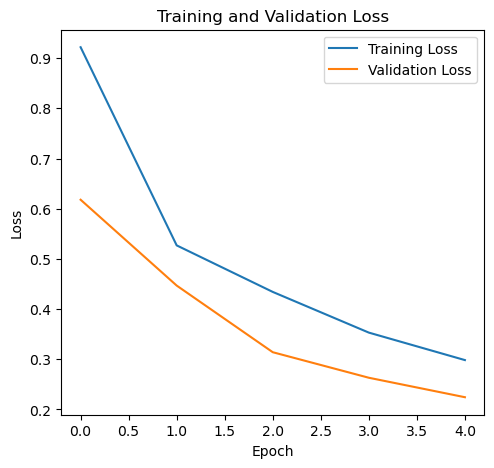

In [22]:
import matplotlib.pyplot as plt
import torch

loss = [l.cpu().numpy() if isinstance(l, torch.Tensor) else l for l in history['loss']]
val_loss = [vl.cpu().numpy() if isinstance(vl, torch.Tensor) else vl for vl in history['val_loss']]

# Plotting the results
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

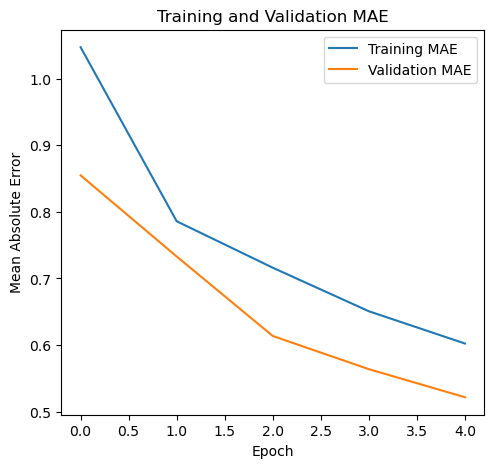

In [23]:
# MAE plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

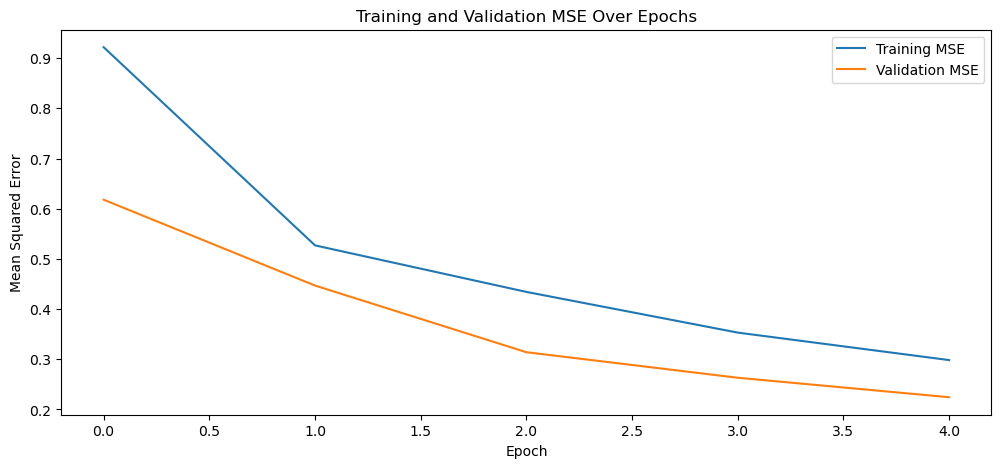

In [24]:
# Graficar el MSE para entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['mse'], label='Training MSE')
plt.plot(history['val_mse'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE Over Epochs')
plt.legend()
plt.show()

In [25]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [26]:
model.eval()
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

In [27]:
submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df.to_csv('submission.csv', index=False)

In [28]:
submission_df

,student_id,content,wording
5732,4e4fee9473e7,-1.247132,-1.478113
5733,2cc3efadc27e,-1.298066,-1.578533
5734,167a2ec7b78b,-1.190603,-1.274941
5735,77e05f8aa4aa,0.141618,0.146317
5736,63e73582ab0e,-1.343732,-1.631536
...,...,...,...
7160,d5f6cae267a4,-1.358836,-1.673710
7161,2aef0f0f01d9,-0.467022,-1.377712
7162,1fa7b128af81,-0.791339,-0.699829
7163,283e9a79445b,0.209526,0.175329


In [29]:
from sklearn.metrics import mean_squared_error
submission_df = pd.read_csv('submission.csv')

mean_squared_error(test_data['content'], submission_df['content']), mean_squared_error(test_data['wording'], submission_df['wording'])

from sklearn.metrics import r2_score

r2_score(test_data['content'], submission_df['content']), r2_score(test_data['wording'], submission_df['wording'])


from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data['content'], submission_df['content']), mean_absolute_error(test_data['wording'], submission_df['wording'])

print("MSE wording: ", mean_squared_error(test_data['wording'], submission_df['wording']))
print("MSE content: ", mean_squared_error(test_data['content'], submission_df['content']))
print("R2 wording: ", r2_score(test_data['wording'], submission_df['wording']))
print("R2 content: ", r2_score(test_data['content'], submission_df['content']))
print("MAE wording: ", mean_absolute_error(test_data['wording'], submission_df['wording']))
print("MAE content: ", mean_absolute_error(test_data['content'], submission_df['content']))

MSE wording:  0.30690557402940116
MSE content:  0.18193962288234578
R2 wording:  0.7289994891522226
R2 content:  0.8324103903782023
MAE wording:  0.42777108460537283
MAE content:  0.3278223373875353


In [31]:
torch.save(model.state_dict(), 'bert.pth')

In [36]:
import pickle

# Guardar el estado del modelo con pickle
with open('bert_model_weights.pkl', 'wb') as f:
    pickle.dump(model, f)


In [38]:
with open('bert_model_weights.pkl', 'rb') as f:
    pruebas = pickle.load(f)


In [39]:
pruebas.eval()

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [40]:
# evaluar pruebas con el test_loader
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = pruebas(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df


,student_id,content,wording
5732,4e4fee9473e7,-1.247132,-1.478113
5733,2cc3efadc27e,-1.298066,-1.578533
5734,167a2ec7b78b,-1.190603,-1.274941
5735,77e05f8aa4aa,0.141618,0.146317
5736,63e73582ab0e,-1.343732,-1.631536
...,...,...,...
7160,d5f6cae267a4,-1.358836,-1.673710
7161,2aef0f0f01d9,-0.467022,-1.377712
7162,1fa7b128af81,-0.791339,-0.699829
7163,283e9a79445b,0.209526,0.175329
